# 20230302_batch_effect_analysis

In [1]:
import sys
import os
from pathlib import Path
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
sys.path.append(SPIKECOUNTER_PATH)

import matplotlib.pyplot as plt
from matplotlib import patches, lines
import matplotlib as mpl
import matplotlib.cm as cmaps
import matplotlib.colors as colors
from matplotlib import gridspec
import colorcet as cc

from scipy import interpolate, signal, stats, optimize, ndimage
import scipy.io as scio
import numpy as np
import skimage.io as skio
from skimage import measure

import pickle
import seaborn as sbs
from parse import *
import seaborn as sns
from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize
from spikecounter.analysis import stats as sc_stats
from sklearn import neighbors
import lmfit
from cycler import cycler
import pandas as pd
import importlib
from statannotations.Annotator import Annotator
biopubs_style = Path(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)

In [2]:
rootdir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure1/")
expts = ["20210420_gcamp_widefield", \
         "20210716_gcamp_widefield", "20210724_gcamp_widefield"]
datadirs = [rootdir/d for d in expts]
subfolder = "corrected"

In [4]:
dFFs = []
offset_times = []
all_peaks = []
ts = []
total_embryos = 0
for datadir in datadirs:
    print(datadir)
    dFF_mat = scio.loadmat(os.path.join(datadir,"dFFs.mat"))
    print(dFF_mat.keys())
    print(dFF_mat['rois'])
    total_embryos += len(dFF_mat['rois'].ravel())
    offset_times.append(dFF_mat["offset_times"].ravel())
    all_peaks.append(pd.read_csv(os.path.join(datadir, "peaks_data.csv"), index_col="roi"))
    dFFs.append(dFF_mat['dFF'])
    ts.append(dFF_mat['t'].ravel())

/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210420_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]]
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210716_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[0 1 2 3 4 5 6 7 8]]
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210724_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17]]


Compare initiation times.

In [5]:
expt_moments = []
for datadir in datadirs:
    expt_moments.append(scio.loadmat(str(datadir/"all_moments.mat")))

In [6]:
all_hpf_starts = []
for moments in expt_moments:
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    print(all_offsets)
    print(len(hpf))
    moments["hpf_start"] = hpf[all_offsets].tolist()[0]
    all_hpf_starts.extend(moments["hpf_start"])

[[418 373 550 186 290 288 268 348 334 209 243 289 224]]
1052
[[268 156 197 200 236 169  84 218 191]]
857
[[219 213 177 268  79 222 215 253 273  57 212 271 221 238 256 186 247]]
782


In [ ]:
bins = np.linspace(np.min(all_hpf_starts), np.max(all_hpf_starts), 20)

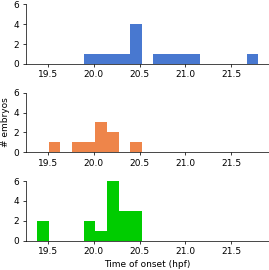

In [11]:
with plt.style.context("../bio_publications.mplstyle"):
    fig1, axes = plt.subplots(3,1, figsize=(4,4))
    for idx, m in enumerate(expt_moments):
        axes[idx].hist(m["hpf_start"], bins = bins, color="C%d" % idx)
        axes[idx].set_ylim(0, 6)

    axes[1].set_ylabel("# embryos")
    axes[2].set_xlabel("Time of onset (hpf)")
    plt.tight_layout()
    plt.savefig(os.path.join(output_data_dir, "initiation_time_by_batch.svg"))

Compare moments between samples

/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210420_gcamp_widefield
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210716_gcamp_widefield
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210724_gcamp_widefield


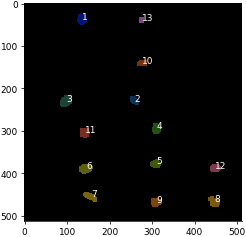

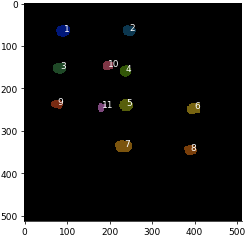

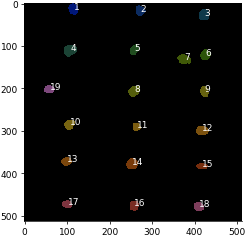

In [7]:
for idx, datadir in enumerate(datadirs):
    print(datadir)
    vid = skio.imread(datadir/"segmentation_video.tif")
    dFF_mat = scio.loadmat(str(datadir/"dFFs.mat"))
    expt_moments[idx]['rois'] =  dFF_mat['rois']
    expt_moments[idx]["roi_mask"] = np.max(vid, axis=0)
    fig1, ax1 = plt.subplots(figsize=(4,4))
    visualize.display_roi_overlay(np.zeros_like(expt_moments[idx]["roi_mask"]), expt_moments[idx]["roi_mask"], ax=ax1, \
                                 mask_cmap="cet_CET_R1")
#     q = ax1.imshow(expt_moments[idx]["roi_mask"])
#     plt.colorbar(q)

In [19]:
reload_libraries()

In [9]:
2.25*4

9.0

In [9]:
for moments in expt_moments:
    print(len(moments["rois"].ravel()))

13
9
17


[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]]
0.04257515280361125 0.7113000206485842
0.14492176798118261 0.20553269670937643
[[0 1 2 3 4 5 6 7 8]]
-0.050222461889292205 0.7711402611076441
0.012355601893429505 0.9429839607415265
[[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17]]
-0.1778114736275277 0.03835751334381721
-0.0625624076120343 0.46932876139730834


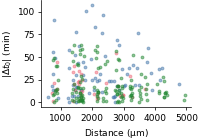

In [12]:
loc_dfs = []
um_per_px = 9
fig1, ax1 = plt.subplots(figsize=(3,2.2))
for idx, moments in enumerate(expt_moments):
    print(moments["rois"])
    rps = pd.DataFrame(measure.regionprops_table(moments["roi_mask"], properties=('label', 'centroid')))
    rps["label"] -= 1
    rps = rps[rps["label"].isin(moments["rois"].ravel())]
    centroids = np.array(rps[["centroid-0", "centroid-1"]])*um_per_px
    loc_df = pd.DataFrame({"expt": [expts[idx]]*centroids.shape[0], 
                           "roi": moments["rois"].ravel(),
                           "centroid_y": centroids[:,0],
                           "centroid_x": centroids[:,1]})
    loc_dfs.append(loc_df)
    pairwise_distances = utils.pairwise_dist(centroids, centroids)
    start_time_diffs = np.abs(np.subtract.outer(moments["hpf_start"], moments["hpf_start"]))
    lower_tri = np.tril(np.ones_like(pairwise_distances, dtype=bool), -1)
    pwd = pairwise_distances[lower_tri]
    st = start_time_diffs[lower_tri]
    all_pwd.extend(list(pwd))
    all_start_delta.extend(list(st*60))
    ax1.scatter(pwd, st*60, alpha=0.5, s=8)
    r, p = stats.pearsonr(pwd, st)
    print(r, p)
    r, p = stats.pearsonr(pwd, np.log(st))
    print(r, p)
ax1.set_xlabel(r"Distance ($\mathrm{\mu m}$)")
ax1.set_ylabel(r"$|\Delta t_0|$ (min)")
plt.tight_layout()
plt.savefig(rootdir/"inter_embryo_distance_vs_timing.svg", dpi=300, bbox_inches="tight")

In [15]:
all_roi_locs = pd.concat(loc_dfs, axis=0)
all_roi_locs.to_csv(rootdir/"widefield_embryo_locs.csv")

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]]
(0.042575152803611245, 0.7113000206485842)
[[0 1 2 3 4 5 6 7 8]]
(-0.0502224618892923, 0.771140261107642)
[[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17]]
(-0.17781147362752775, 0.03835751334381729)


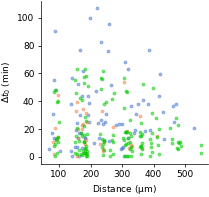

In [15]:
fig1, ax1 = plt.subplots(figsize=(3,3))
for moments in expt_moments:
    print(moments["rois"])
    rps = pd.DataFrame(measure.regionprops_table(moments["roi_mask"], properties=('label', 'centroid')))
    rps["label"] -= 1
    rps = rps[rps["label"].isin(moments["rois"].ravel())]
    centroids = np.array(rps[["centroid-0", "centroid-1"]])
    pairwise_distances = utils.pairwise_dist(centroids, centroids)
    start_time_diffs = np.abs(np.subtract.outer(moments["hpf_start"], moments["hpf_start"]))
    lower_tri = np.tril(np.ones_like(pairwise_distances, dtype=bool), -1)
    pwd = pairwise_distances[lower_tri]
    st = start_time_diffs[lower_tri]
    ax1.scatter(pwd, st*60, alpha=0.5, s=8)
    print(stats.pearsonr(pwd, st))
ax1.set_xlabel(r"Distance ($\mathrm{\mu m}$)")
ax1.set_ylabel(r"$\Delta t_0$ (min)")
plt.savefig(os.path.join(output_data_dir, "distance_vs_timing.svg"))

/tmp/ipykernel_24140/4274873700.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_24140/4274873700.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_24140/4274873700.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof

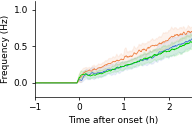

In [17]:
fig1, ax1 = plt.subplots(figsize=(3,2))
for i in range(3):
    moments = expt_moments[i]
    aligned_frequencies = moments["all_freqs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_freq = np.nanmean(aligned_frequencies, axis=0)
    std_freq = np.nanstd(aligned_frequencies, axis=0)
    x = (np.arange(len(mean_freq)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_freq, color="C%d" % i)
    ax1.fill_between(x, mean_freq-std_freq, mean_freq+std_freq, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")
ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlim(-1, 2.5)
plt.tight_layout()
plt.savefig(os.path.join(output_data_dir, "batch_frequency.svg"))

/tmp/ipykernel_24140/3813817735.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_24140/3813817735.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_24140/3813817735.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


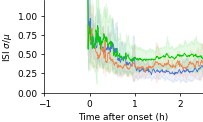

In [18]:
fig1, ax1 = plt.subplots(figsize=(3,2))
for i in range(3):
    moments = expt_moments[i]   
    aligned_covs = moments["covs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_cov = np.nanmean(aligned_covs, axis=0)
    std_cov = np.nanstd(aligned_covs, axis=0)
    x = (np.arange(len(mean_cov)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_cov, color="C%d" % i)
    ax1.fill_between(x, mean_cov-std_cov, mean_cov+std_cov, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")
ax1.set_ylim(0,1.2)
ax1.set_xlim(-1, 2.5)
ax1.set_ylabel(r"ISI $\sigma/\mu$")
plt.tight_layout()
plt.savefig(os.path.join(output_data_dir, "batch_cv.svg"))